# Deep Chemometrics with Data Augmentation
This is an example of how to build a simple convolutional neural network (CNN) to build predictive models from spectroscopical data (Deep Chemometrics). The dataset consists of NIR measurements of pharmaceutical tablets together with information about content of the active ingredients measured in the laboratory. We will use deep learning technology together with spectroscopical data augmentation to build a predictive model. The background and concept is further described in the preprint which can be downloaded free of charge from https://arxiv.org/pdf/1710.01927.pdf and also featuring in the blog post: https://www.wildcardconsulting.dk/useful-information/deep-chemometrics-deep-learning-for-spectroscopy/

## Dataset
The dataset can be downloaded from http://www.eigenvector.com/data/tablets/index.html and should be placed in the Dataset folder. It is a MATLAB format file, but using the scipy.io module, it can be loaded into Python

In [1]:
import scipy.io as sio
import numpy as np

def get_xY(filename, maxx=600):
    
    #sio.whosmat(filename)

    matcontents = sio.loadmat(filename)
    keys = list(matcontents.keys())
    for key in list(keys):
        if key[0] == '_':
            keys.remove(key)
            
    keys.sort()
            
    d = {}            
    for key in keys:
        data = matcontents[key][0][0]
        if key[-1] == "Y":
            Ydata = data[5]
            d[key] = Ydata
        else:
            xdata = data[5][:,:maxx]
            d[key] = xdata
            d["axisscale"]= data[7][1][0][0][:maxx].astype(np.float)
                    
    return d

filename = 'Dataset/nir_shootout_2002.mat'
dataset = get_xY(filename)

The data set contains measurements on the same tablets from two spectrometers, and are alreade divided into calibration, validation and test sets

In [2]:
dataset.keys()

dict_keys(['calibrate_1', 'axisscale', 'calibrate_2', 'calibrate_Y', 'test_1', 'test_2', 'test_Y', 'validate_1', 'validate_2', 'validate_Y'])

Using matplotlib, the spectrums can be plotted

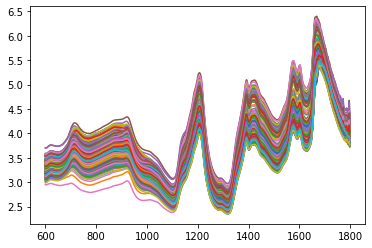

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.plot(dataset['axisscale'],dataset['test_1'].T)

Neural networks like the input and output to be near the -1 to 1 range, so the GlobalStandardScaler object will be used to scale it to unit mean and 1/2.5 standard deviation. It works on a global scale, not per feature as is otherwise the norm for scikit-learn scalers.

1.0000000000000002
-4.6133789220365925e-17
4.016602295406501
(460, 600)


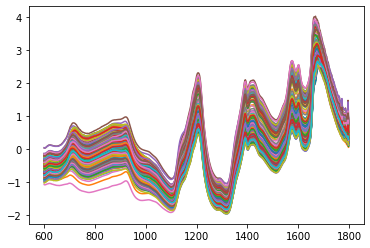

In [5]:
#Rescale to NN friendly number range
from ChemUtils import GlobalStandardScaler

xscaler = GlobalStandardScaler()

#Calibrate is smaler than test, so they are swapped
X_train = xscaler.fit_transform(dataset['test_1']) #From instrument 1
X_test = xscaler.transform(dataset['calibrate_2']) #! NB only transform on test set. From instrument 2

print (X_train.std())
print (X_train.mean())
print (X_train.max())
_ = plt.plot(dataset['axisscale'],X_train.T)
print(X_train.shape)

The differences between spectrums are not changed, but the range is adjusted and the mean moved to zero. Below, we also scale the measured API concentration with another GlobalScaler (Here scikit learns standard scaler would also have worked)

In [6]:
yscaler = GlobalStandardScaler()
y_train = yscaler.fit_transform(dataset['test_Y'][:,2])
y_test = yscaler.transform(dataset['calibrate_Y'][:,2]) 

In [1]:
print(dataset['test_Y'][:,2])

NameError: name 'dataset' is not defined

# Data Augmentation
Instead of correction of the baseline variations we use a special implementation of data augmentation. The idea is to simulate the expected form of irrelevant noise (here baseline offset and slope and overall spectrum intensity), and expect the neural network to either extract features robust to the variations, or figure out the best corrections during training. This way we can make more efficient use of the labelled dataset. The idea is similar to the image rotations and croppings done in image recognition training.

In [8]:
#Expand dataset, Function also available in ChemUtils
def dataaugment(x, betashift = 0.05, slopeshift = 0.05,multishift = 0.05):
    #Shift of baseline
    #calculate arrays
    beta = np.random.random(size=(x.shape[0],1))*2*betashift-betashift
    slope = np.random.random(size=(x.shape[0],1))*2*slopeshift-slopeshift + 1
    #Calculate relative position
    axis = np.array(range(x.shape[1]))/float(x.shape[1])
    #Calculate offset to be added
    offset = slope*(axis) + beta - axis - slope/2. + 0.5

    #Multiplicative
    multi = np.random.random(size=(x.shape[0],1))*2*multishift-multishift + 1

    x = multi*x + offset

    return x

To illustrate what data augmentation does, lets try and augment the first spectrum with large constants

(10, 600)


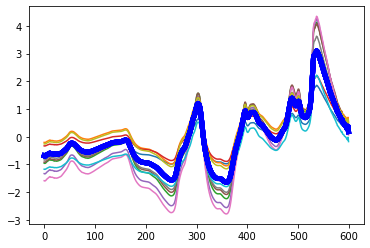

In [9]:
#Data Augment a single spectrum

#First Spectrum
X = X_train[0:1]
#Repeating the spectrum 10x
X = np.repeat(X, repeats=10, axis=0)
#Augment (Large pertubations for illustration)
X_aug = dataaugment(X,betashift = 0.5, slopeshift = 0.5,multishift = 0.5)
    
plt.plot(X_aug.T)
_= plt.plot(X.T, lw=5, c='b')
print(X_aug.shape)

The fat blue line is the original spectrum and the others are the modified ones. Lets apply this to all the spectrums and expand the dataset with a factor of 100. I've found that the offset and multiplication works OK around 10% of the standard deviation for the whole dataset. The slopeshift is set to half of this. This could vary depending on the dataset and may be worth experimenting with.

In [11]:
shift = np.std(X_train)*0.1
shift

0.10000000000000003

46000
46000
(46000, 600)


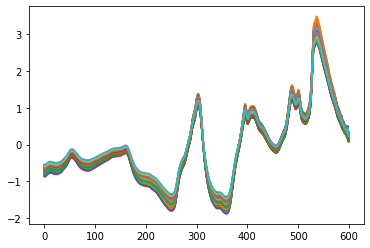

In [13]:
X_train_aug = np.repeat(X_train, repeats=100, axis=0)
X_train_aug = dataaugment(X_train_aug, betashift = shift, slopeshift = 0.05, multishift = shift)

y_train_aug = np.repeat(y_train, repeats=100, axis=0) #y_train is simply repeated


print (len(X_train_aug))
print (len(y_train_aug))
_ = plt.plot(X_train_aug[0:100].T)
print(X_train_aug.shape)

As an alternative to a fixed size augmented dataset, Keras can also use generator objects, which generates batches "on the fly", solving memory problems and giving even larger augmented datasets. Checkout the code at https://github.com/EBjerrum/SMILES-enumeration to see an example from another data domain I have been experimenting with.

# Neural Network definition and training

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Reshape, GaussianNoise
from keras.callbacks import ReduceLROnPlateau


After importing the Keras objects, the network can be build. It consists of two convolutional layers, followed by a flattening to give a 1D vector, whose output is fed to a dense layer with the relu activation function which feed a single output neuron. Dropout is added after the flatten layer where there are the most connections. The mean square error function is used ("mse") and an adadelta optimizer with a lr lowered from the default.

In [18]:
#Hyperparameters for the network
DENSE = 128
DROPOUT = 0.5
C1_K  = 8 #Number of kernels/feature extractors for first layer
C1_S  = 32 #Width of the convolutional mini networks
C2_K  = 16
C2_S  = 32
activation='relu'

input_dim = X_train.shape[1]

#The model
def make_model():
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.05, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(Reshape((input_dim, 1) ))
    model.add(Conv1D(C1_K, (C1_S), activation=activation, padding="same"))
    model.add(Conv1D(C2_K, (C2_S), padding="same", activation=activation))
    model.add(Flatten())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation=activation))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))

    return model

In [19]:
model = make_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 600)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 600, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 600, 8)            264       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 600, 16)           4112      
_________________________________________________________________
flatten (Flatten)            (None, 9600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 9600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)              

Are we really going to fit a model with millions of parameters to a dataset coming from some hundred spectrums? The low number of parameters in the first layers and the fact that the convolutions need to work on the entire spectrum will help.

To lower the learning rate, the ReduceLROnPlateau Keras callback is used.

In [20]:
rdlr = ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

h = model.fit(X_train_aug, y_train_aug, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[rdlr])

Epoch 1/50
2875/2875 [==============================] - 39s 14ms/step - loss: 0.5334 - val_loss: 0.4100
Epoch 2/50
2875/2875 [==============================] - 39s 14ms/step - loss: 0.2053 - val_loss: 0.1480
Epoch 3/50
2875/2875 [==============================] - 38s 13ms/step - loss: 0.1569 - val_loss: 0.1087
Epoch 4/50
2875/2875 [==============================] - 39s 14ms/step - loss: 0.1383 - val_loss: 0.1065
Epoch 5/50
2875/2875 [==============================] - 39s 14ms/step - loss: 0.1284 - val_loss: 0.1056
Epoch 6/50
2875/2875 [==============================] - 39s 14ms/step - loss: 0.1221 - val_loss: 0.1012
Epoch 7/50
2875/2875 [==============================] - 39s 14ms/step - loss: 0.1185 - val_loss: 0.1081
Epoch 8/50
2875/2875 [==============================] - 39s 13ms/step - loss: 0.1141 - val_loss: 0.0985
Epoch 9/50
2875/2875 [==============================] - 39s 13ms/step - loss: 0.1112 - val_loss: 0.1006
Epoch 10/50
2875/2875 [==============================] - 39s 14m

KeyboardInterrupt: 

Note: The loss for the training is including active dropout layer. For prediction the dropout is turned off and the weights adjusted in the layer. This gives a higher loss for training that will otherwise be seen if the training set is tested afterwards. Training is stochastic process, and sometimes the training will not behave. Removing outliers and tuning the learning rate and batchsize may help.

No handlers could be found for logger "matplotlib.legend"


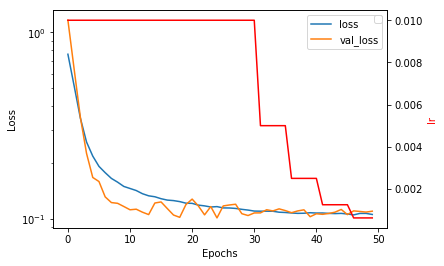

In [19]:

plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
ax2 = plt.gca().twinx()
ax2.plot(h.history['lr'], color='r')
ax2.set_ylabel('lr',color='r')

plt.legend()

The "history" object returned by the training, contain the losses and learning rates from the training. The loss for the training and validation (here = Test) settles down when the lr is lowered. The model seems a bit overfit as the validation loss rises towards the end of training, maybe a higher dropout ratio could help.

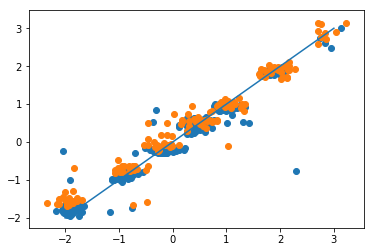

In [20]:
plt.scatter(y_train, model.predict(X_train))
plt.scatter(y_test, model.predict(X_test))
plt.plot([-2,3],[-2,3]) # Y = PredY line

This doesn't look so bad for network predicting results from a different spectrofotometer! Tuning of hyperparameters can improve the results further and outliers do not magically disapper just because we use deep learning. I recommend to use a validation/development set for tuning and not the test set.

In [21]:
#Some metrics
def huber(y_true, y_pred, delta=1.0):
	y_true = y_true.reshape(-1,1)
	y_pred = y_pred.reshape(-1,1)
	return np.mean(delta**2*( (1+((y_true-y_pred)/delta)**2)**0.5 -1))

In [22]:
def benchmark(X_train,y_train,X_test, y_test, model):
    rmse = np.mean((y_train - model.predict(X_train).reshape(y_train.shape))**2)**0.5
    rmse_test = np.mean((y_test - model.predict(X_test).reshape(y_test.shape))**2)**0.5
    hub = huber(y_train, model.predict(X_train))
    hub_test = huber(y_test, model.predict(X_test))
    print ("RMSE  Train/Test\t%0.2F\t%0.2F"%(rmse, rmse_test))
    print ("Huber Train/Test\t%0.4F\t%0.4F"%(hub, hub_test))

In [23]:
benchmark(X_train, y_train, X_test, y_test, model)

RMSE  Train/Test	0.25	0.33
Huber Train/Test	0.0230	0.0496


The other example show an example of the performance a similar network can obtain with EMSC correction of baseline instead of data augmentation. Huber loss is an error function that is less sensitive to outliers than standard RMSE